In [1]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer, average_precision_score, precision_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
# from lightgbm import log_evaluation

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import plot_missing_proportion_barchart, get_cols
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, CONFIRM_DROP_FEATURES
)

In [4]:
DATA_PATH = "../raw_data"
os.listdir(DATA_PATH)

['train_labels.csv',
 '.DS_Store',
 'train_pickle',
 'train_lag0_post_format.pkl',
 'train_lag0_pre_format.pkl',
 '.ipynb_checkpoints',
 'test_parquet',
 'train_parquet',
 'sample_submission.csv',
 'test_pickle']

In [5]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [6]:
%load_ext autoreload
%autoreload

In [7]:
RAW_TRAIN_CSV_PATH = os.path.join(RAW_DATA_PATH, "train_csv")
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TRAIN_FEATHER_PATH = os.path.join(RAW_DATA_PATH, "train_ftr")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

### Read Data

In [8]:
id_mapping_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/id_mapping_df.csv")
labels_df = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [9]:
%%time
df = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data.pkl")
# df = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data.pkl")

Shape of data: (5531451, 191)
CPU times: user 5.09 s, sys: 3.57 s, total: 8.66 s
Wall time: 9.25 s


In [10]:
# df = df.drop(columns="customer_ID", errors="ignore")

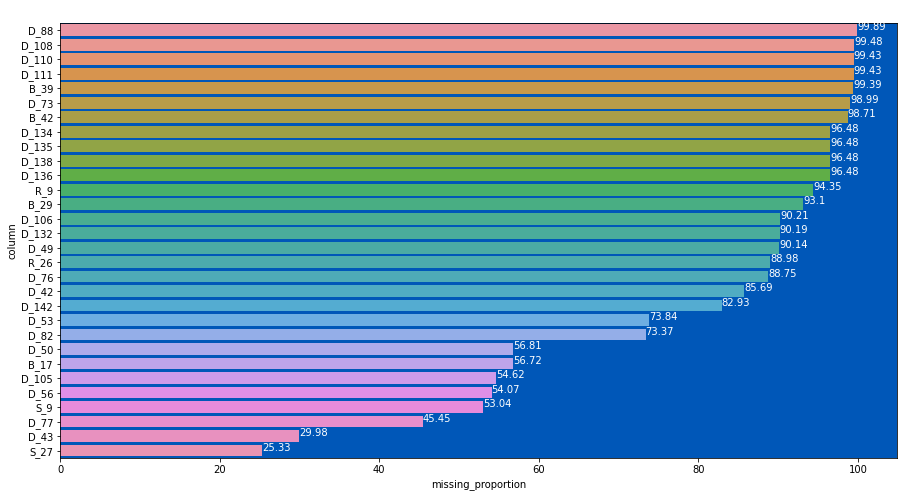

In [11]:
null_count_df = plot_missing_proportion_barchart(df)

In [12]:
if "row_number" not in df.columns:
    df.insert(1, "row_number", df.groupby("customer_ID")["S_2"].rank(method="first", ascending=False).astype(int))

In [13]:
# df.to_pickle(f"{RAW_TRAIN_PICKLE_PATH}/train_data.pkl")

### Get Full Model & Feature Engineering

In [14]:
# df_lag1 = df.loc[df["row_number"] <= 2].reset_index(drop=True)
# del df

In [15]:
# plt.figure(figsize=(20, 10))
# sns.heatmap(df_lag0.select_dtypes("int8").corr(), cmap="coolwarm", annot=True)
# plt.show()

In [16]:
# corr_df = df_lag0.loc[:, CONTINUOUS_COLUMNS].corr()

In [17]:
# for column in corr_df.columns:
#     pass
# corr_df[column].index

In [18]:
# np.corrcoef(df_lag0["P_2"], df_lag0["target"])

In [19]:
# for f in tqdm(features):
#     if not df_lag0[f].dtype == "category":
#         corr_coef = np.corrcoef(df_lag0[f], df_lag0["target"])
#         print(f"Feature {f} with target has Pearson corr of {corr_coef:.3f}")

In [20]:
# df1 = df_lag1.loc[df_lag1["row_number"] == 1]
# df2 = df_lag1.loc[df_lag1["row_number"] == 2]

In [21]:
cid_list = id_mapping_df["customer_ID"].tolist()

In [ ]:
df2 = df2.rename(columns={k: f"{k}_prev" for k in df2.columns[3:-1]}).drop(columns=["S_2", "row_number", "target"])

In [ ]:
df12 = df1.merge(df2, on="customer_ID", how="left")

In [ ]:
prev_columns = sorted(df2.columns[1:].tolist())

In [ ]:
index = 1
prev_col = prev_columns[index]
curr_col = prev_col.replace("_prev", "")
curr_col

In [ ]:
df12[curr_col].describe()

In [ ]:
(df12[curr_col] - df12[prev_col]).describe()

In [ ]:
df12[[curr_col, prev_col]].corr()

In [ ]:
# df12.loc[:, f"{curr_col}_mean"] = df12.loc[:, curr_col] - df12.loc[:, prev_col]

### Full Model

In [22]:
special_columns = ['customer_ID', 'row_number', 'S_2', 'target']

In [23]:
all_cols = [c for c in df.columns if c not in special_columns]
cat_features = CATEGORY_COLUMNS
num_features = [col for col in all_cols if col not in CATEGORY_COLUMNS]

In [24]:
len(all_cols), len(cat_features), len(num_features)

(187, 11, 176)

In [25]:
df.shape

(5531451, 191)

In [26]:
# test_agg_summary = get_agg_summary(df)

In [27]:
%%time
df_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'max', 'min', 'last', 'first'])
df_agg.columns = ['_'.join(x) for x in df_agg.columns]

CPU times: user 43.9 s, sys: 7.73 s, total: 51.6 s
Wall time: 53.1 s


In [28]:
# test_agg = pd.concat([test_agg_summary, test_data_agg], axis=1)
# del test_agg_summary, test_data_agg

In [29]:
df_cat_agg = df.groupby("customer_ID")[cat_features].agg(['last'])
df_cat_agg.columns = ['_'.join(x) for x in df_cat_agg.columns]

In [30]:
df_agg = pd.concat([df_agg, df_cat_agg], axis=1)
del df_cat_agg

In [31]:
df_agg.shape

(458913, 891)

In [32]:
del df

In [33]:
df_agg = df_agg.merge(labels_df, on="customer_ID", how="left")

### Pre Training Feature Selection

In [36]:
mean_features = [f"{col}_mean" for col in MEAN_FEATURES]
mean_features[:3]

['B_1_mean', 'B_2_mean', 'B_3_mean']

In [37]:
min_features = [f"{col}_min" for col in MIN_FEATURES]
min_features[:3]

['B_2_min', 'B_4_min', 'B_5_min']

In [38]:
max_features = [f"{col}_max" for col in MAX_FEATURES]
max_features[:3]

['B_1_max', 'B_2_max', 'B_3_max']

In [39]:
last_features = [f"{col}_last" for col in LAST_FEATURES]
last_features[:3]

['B_1_last', 'B_2_last', 'B_3_last']

In [41]:
temp_last = [f"{c}_last" for c in num_features]
temp_first = [f"{c}_first" for c in num_features]

In [48]:
for last_, first_ in zip(temp_last, temp_first):
    df_agg[f'{last_.replace("_last", "")}_displacement'] = (df_agg[last_] - df_agg[first_]) * 100

In [50]:
temp_max = [f"{c}_max" for c in num_features]
temp_min = [f"{c}_min" for c in num_features]

In [51]:
for max_, min_ in zip(temp_max, temp_min):
    df_agg[f'{max_.replace("_max", "")}_range'] = (df_agg[max_] - df_agg[min_]) * 100

In [73]:
temp_range = [f"{c}_range" for c in num_features]
temp_displacement = [f"{c}_displacement" for c in num_features]

In [74]:
for range_, displacement_ in zip(temp_range, temp_displacement):
    try:
        df_agg[f'{range_.replace("_range", "")}_speed'] = (df_agg[displacement_] / (df_agg[range_] + 1))
    except:
        pass

In [76]:
std_series = df_agg.std()

In [77]:
low_std_features = std_series[std_series < 0.001]
low_std_features

D_44_mean      0.0
D_44_max       0.0
D_44_min       0.0
D_44_last      0.0
D_44_first     0.0
              ... 
D_137_speed    0.0
D_139_speed    0.0
D_140_speed    0.0
D_143_speed    0.0
D_145_speed    0.0
Length: 250, dtype: float64

In [79]:
df_agg = df_agg.drop(columns=low_std_features.index.tolist())

In [82]:
missing_series = (df_agg.isnull().sum() / df_agg.shape[0])

In [84]:
high_missing_features = missing_series[missing_series > 0.9]
high_missing_features

D_73_mean      0.982550
D_73_max       0.982550
D_73_min       0.982550
D_73_last      0.982550
D_73_first     0.982550
                 ...   
B_42_speed     0.985816
D_134_speed    0.924700
D_135_speed    0.924700
D_136_speed    0.924700
D_138_speed    0.924700
Length: 96, dtype: float64

In [85]:
df_agg = df_agg.drop(columns=high_missing_features.index.tolist())

In [91]:
first_features = [c for c in df_agg.columns if c.endswith("first")]

In [92]:
df_agg = df_agg.drop(columns=first_features)

In [93]:
df_agg.shape

(458913, 942)

### Lag1 Model Training

In [94]:
train, val = train_test_split(df_agg, test_size=0.2, random_state=1, stratify=df_agg["target"])

In [95]:
train.shape, val.shape

((367130, 942), (91783, 942))

In [96]:
target = train["target"].values

In [104]:
del df_agg

In [98]:
features = df_agg.columns[1:].tolist()
features = [f for f in features if f != "target"]
features[:5], features[-5:]

(['P_2_mean', 'P_2_max', 'P_2_min', 'P_2_last', 'D_39_mean'],
 ['D_133_speed', 'R_28_speed', 'D_141_speed', 'D_142_speed', 'D_144_speed'])

In [99]:
X_train = train.loc[:, features]
X_val = val.loc[:, features]

In [46]:
y_train = train["target"].values
y_val = val["target"].values

In [ ]:
params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "reg_alpha": 3.5,
    "reg_lambda": 12,
    "learning_rate": 0.05,
    "n_estimators": 420,
    "colsample_bytree": 0.35,
    "subsample": 0.612,
    "subsample_freq": 5,
    "min_child_samples": 165,
    "scale_pos_weight": 1.7,
    "max_bins": 215,
    "max_depth": 17,
    "num_leaves": 130000
}

In [ ]:
model = LGBMClassifier(**params)

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)], 
        eval_metric=[lgb_amex_metric],
    )

In [ ]:
y_train_pred = model.predict_proba(X_train, raw_score=True)
train_score = amex_metric(y_train, y_train_pred)
y_val_pred = model.predict_proba(X_val, raw_score=True)
val_score = amex_metric(y_val, y_val_pred)

In [ ]:
print(f"Train Score = {train_score:.5f}")
print(f"Val   Score = {val_score:.5f}")

### Lag0 Model Tuning

In [105]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5)
    
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 20, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 40, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 500, 800),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.4),
        "subsample": trial.suggest_float("subsample", 0.55, 0.85),
        "subsample_freq": trial.suggest_int("subsample_freq", 2, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 200, 250),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.25, 1.75),
        "max_bins": trial.suggest_int("max_bins", 160, 250),
        "max_depth": trial.suggest_int("max_depth", 25, 50),
    }
    params["learning_rate"] = 0.05
    params["num_leaves"] = 131072 # int(2 ** (params["max_depth"] - 5))
    print(params)
    
    score_list = []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train, target)):
        X_train, X_val, y_train, y_val, model = None, None, None, None, None
        X_train = train.iloc[idx_tr][features]
        X_val = train.iloc[idx_va][features]
        y_train = target[idx_tr]
        y_val = target[idx_va]
        model = LGBMClassifier(**params)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_val, y_val)], 
                eval_metric=[lgb_amex_metric],
                verbose=-1
                # callbacks=[log_evaluation(params["n_estimators"])]
            )
        y_train_pred = model.predict_proba(X_train, raw_score=True)
        train_score = amex_metric(y_train, y_train_pred)
        X_train, y_train = None, None
        y_val_pred = model.predict_proba(X_val, raw_score=True)
        val_score = amex_metric(y_val, y_val_pred)
        print(f"Fold {fold} | Train Score = {train_score:.5f}")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
        score_list.append(val_score)

    return np.mean(score_list)

In [106]:
study = optuna.create_study(direction="maximize")

[I 2022-07-09 16:36:59,373] A new study created in memory with name: no-name-90b60280-b554-4c3d-98ff-c30a8fedf0a5


In [ ]:
study.optimize(objective, n_trials=50)

{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 0.6493879389506618, 'reg_lambda': 7.5481323055231755, 'learning_rate': 0.05, 'n_estimators': 535, 'colsample_bytree': 0.2610759513799835, 'subsample': 0.5686866186177526, 'subsample_freq': 2, 'min_child_samples': 215, 'scale_pos_weight': 1.7347892551438318, 'max_bins': 162, 'max_depth': 38, 'num_leaves': 131072}
[LightGBM] [Warning] Unknown parameter: max_bins


In [ ]:
trial_df = study.trials_dataframe()

In [ ]:
# trial_df.loc[trial_df["state"] == "COMPLETE"].to_csv(f"{EVALUATION_DATA_PATH}/trials/ori_lag0_gbdt.csv", index=False)

In [ ]:
# for col in trial_df.columns[5:-1]:
#     plt.figure(figsize=(16, 8))
#     sns.scatterplot(data=trial_df.dropna(), x=col, y="value")
#     plt.title(f"{col}")
#     plt.show()

In [ ]:
trial_df.loc[trial_df["value"].argmax()]

In [ ]:
%%time
corr_df = df.iloc[:, 3:-1].corr()

In [ ]:
null_count_df = df.iloc[:, 3:-1].isnull().sum().sort_values()

In [ ]:
potential_to_impute_columns = null_count_df[(null_count_df > 0) & (null_count_df < df.shape[0] * 0.2)].index.tolist()
potential_to_impute_null_counts = null_count_df[(null_count_df > 0) & (null_count_df < df.shape[0] * 0.2)].values.tolist()

In [ ]:
impute_col_index = 0

In [ ]:
target_impute_column = potential_to_impute_columns[impute_col_index]
target_impute_column

In [ ]:
target_impute_null_count = potential_to_impute_null_counts[impute_col_index]
target_impute_null_count

In [ ]:
high_corr_df = corr_df.loc[
    ~corr_df[target_impute_column].between(-0.4, 0.4) & ~corr_df[target_impute_column].isnull(),
    target_impute_column
]
high_corr_df = high_corr_df.abs().sort_values(ascending=False)
high_corr_df

In [ ]:
potential_features = high_corr_df.index.tolist()
potential_features.remove(target_impute_column)
print(potential_features)

In [ ]:
potential_features_null_count = df.loc[:, potential_features].isnull().sum()
potential_features = potential_features_null_count[potential_features_null_count == 0].index.tolist()
if len(potential_features) > 10:
    potential_features = potential_features[:10]
potential_features

In [ ]:
if len(potential_features) > 0:
    temp = df.loc[df[target_impute_column].isnull(), potential_features + [target_impute_column]]
    print(f"{len(potential_features)} potential feature(s), showing the target column against the first feature")
    sns.scatterplot(data=df, 
                    x=potential_features[0], 
                    y=target_impute_column)
    plt.show()
else:
    temp = df.loc[df[target_impute_column].isnull(), ["customer_ID", "row_number", target_impute_column]]
    print("No potential features, proceed with mean imputation")
    df.loc[df[target_impute_column].isnull(), target_impute_column] = df[target_impute_column].mean()
    print(f"Imputed {len(temp.index)} rows of data")

In [ ]:
# df[target_impute_column].plot.box()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
all_data = df.loc[:, ["customer_ID"] + potential_features + [target_impute_column]]

In [ ]:
train_val = all_data.loc[~all_data[target_impute_column].isnull()]
test = all_data.loc[all_data[target_impute_column].isnull()]

In [ ]:
train, val = train_test_split(train_val, test_size=0.2, random_state=1)

In [ ]:
test

In [ ]:
train.shape, val.shape, test.shape

In [ ]:
X_train = train.loc[:, potential_features]
X_val = val.loc[:, potential_features]
X_test = test.loc[:, potential_features]
y_train = train[target_impute_column]
y_val = val[target_impute_column]
y_test = test[target_impute_column]

In [ ]:
%%time
min_mse = np.inf
for k in [3, 5, 9, 13]:
    knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    if mse < min_mse:
        min_mse = mse
        best_knn_model = knn_model
        print(f"K: {k}, Validation MSE: {min_mse:.6f}")

In [ ]:
y_test

In [ ]:
df.loc[y_test.index, target_impute_column] = knn_model.predict(X_test)

In [ ]:
df.loc[y_test.index, target_impute_column]

In [ ]:
end

### END

### Copy from Kaggle

In [ ]:
ma_features = [col for col in train_data.columns if col.endswith("_ma")]
ma_features[:3]

In [ ]:
target = train_data["target"].values.astype(int)

In [ ]:
%%time
# Cross-validation of the classifier
ONLY_FIRST_FOLD = False
features = min_features + max_features + last_features + ma_features # mean_features + 
excluded_columns = ['B_30_mean', 'B_38_mean', 'D_114_mean', 'D_117_mean', 'D_120_mean', 'D_126_mean', 
                    'B_30_max', 'B_38_max', 'D_63_max', 'D_64_max', 'D_116_max', 'D_117_max', 'D_126_max',
                    'D_68_last', 'D_117_last']
features = [f for f in features if f not in excluded_columns]
print(f"{len(features)} features")

In [ ]:
def my_booster(random_state=1, n_estimators=1400):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, 
                          reg_alpha=10, 
                          reg_lambda=40,
                          min_child_samples=2200,
                          num_leaves=100,
                          colsample_bytree=0.18,
                          subsample=0.85,
                          max_bins=500, 
                          scale_pos_weight=2.5,
                          random_state=1)

In [ ]:
# train[["D_63_last", "D_64_last"]] = train[["D_63_last", "D_64_last"]].astype("category")

In [ ]:
# train = train_data.copy()
# del train_data

In [ ]:
n_est_list = [2200, 1500, 2000, 1000, 1600, 1800, 1800, 1200, 1400, 1000]

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i)
    raw_score_ = y_score_dict[i]
    target_ = y_val_dict[i]
    main_metric, gini, top4 = amex_metric_np(raw_score_, target_)
    print(f"Main metric: {main_metric:.3f}, Gini: {gini:.3f}, Top4: {top4:.3f}")
    prob_score_ = sigmoid(raw_score_)
    print(f"ROC AUC: {roc_auc_score(target_, prob_score_):.3f}")
    print(f"Average Precision: {average_precision_score(target_, prob_score_):.3f}")

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

In [ ]:
full_train["prob_score"] = sigmoid(full_train["score"])

In [ ]:
roc_auc_score(full_train["target"], full_train["prob_score"])

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train = full_train.sort_values('score', ascending=False)

In [ ]:
full_train['weight'] = full_train['target'].apply(lambda x: 20 if x==0 else 1)

In [ ]:
four_pct_cutoff = int(0.04 * full_train['weight'].sum())
full_train['weight_cumsum'] = full_train['weight'].cumsum()
full_train["is_cutoff"] = 0
full_train.loc[full_train['weight_cumsum'] <= four_pct_cutoff, "is_cutoff"] = 1

In [ ]:
top_four_pct_df = full_train.loc[full_train["is_cutoff"] == 1]

In [ ]:
full_train.shape, top_four_pct_df.shape

In [ ]:
top_four_pct_df["target"].mean()

In [ ]:
full_train.describe().iloc[:, :-5].reset_index().to_csv(f"{EVALUATION_DATA_PATH}/train_description.csv", index=False)

In [ ]:
all_neg = full_train.loc[full_train["target"] == 0]
all_pos = full_train.loc[full_train["target"] == 1]

In [ ]:
wrong_top = top_four_pct_df.loc[top_four_pct_df["target"] == 0]
correct_top = top_four_pct_df.loc[top_four_pct_df["target"] == 1]

In [ ]:
wrong_top.shape, correct_top.shape

In [ ]:
col = "B_2_min"
plt.figure(figsize=(14, 8))
sns.distplot(wrong_top[col], kde=True, hist=False, label="Wrong")
sns.distplot(correct_top[col], kde=True, hist=False, label="Right")
plt.legend()
plt.show()

In [ ]:
wrong_top["B_2_min"].min(), correct_top["B_2_min"].min()

In [ ]:
rule_list = []
for col in wrong_top.columns:
    try:
        pos_minimum = all_pos[col].min()
        temp = wrong_top.loc[wrong_top[col] < pos_minimum]
        if temp.shape[0] > 0:
            # print(col, f"Minimum bound for positive class {pos_minimum}")
            rule_list.append((col, "Minimun", pos_minimum))
        pos_maximum = all_pos[col].max()
        temp = wrong_top.loc[wrong_top[col] > pos_maximum]
        if temp.shape[0] > 0:
            # print(col, f"Maximum bound for positive class {pos_maximum}")
            rule_list.append((col, "Maximum", pos_maximum))
    except:
        continue

In [ ]:
rule_df = pd.DataFrame(rule_list, columns=["feature", "type", "value"])

In [ ]:
# rule_df.to_csv(f"{EVALUATION_DATA_PATH}/rule_df.csv", index=False)

In [ ]:
correct_top.describe()

In [ ]:
full_train

In [ ]:
X = top_four_pct_df.iloc[:, :-5].select_dtypes("float").reset_index(drop=True)
y = top_four_pct_df["target"].reset_index(drop=True)

In [ ]:
# for col in X.columns:
#     if X[col].isnull().sum() > 0:
#         X[col] = X[col].fillna(X[col].mean())
#         print(col, X[col].mean())

In [ ]:
y_val_pred

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va) in zip(range(1, 10+1), kf.split(X, y)):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = X.iloc[idx_tr]
    X_val = X.iloc[idx_va]
    y_train = y[idx_tr]
    y_val = y[idx_va]
    
    model = LogisticRegression(random_state=1020)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train)
    
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val)[:, 1]
    # print(precision_score(y_val, sigmoid(y_val_pred)))
    score = amex_metric(np.array(y_val), y_val_pred)
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
for idx, model in enumerate(model_list):
    joblib.dump(model, f'../models/lgbm_models/model_{idx+1}.pkl')

### Train Val Split

In [ ]:
train, val = train_test_split(train_data, test_size=0.175, random_state=923, stratify=train_data["target"])

In [ ]:
train["target"].mean(), val["target"].mean()

In [ ]:
special_columns = ['customer_ID', 'S_2', 'target', "Date", "min_date", "max_date", "num_records", "days", "record_per_day"]

In [ ]:
all_cols = [c for c in train.columns if c not in special_columns]
cat_features = train.select_dtypes("category").columns.tolist()
num_features = [col for col in all_cols if col not in cat_features]

In [ ]:
len(all_cols), len(cat_features), len(num_features)

In [ ]:
cluster_columns = get_cols(train, "_cluster")
nunique_columns = get_cols(train, "_nunique")
non_D66_count_columns = [col for col in get_cols(train, "_count") if "D_66" not in col]

In [ ]:
selected_features = list(set(all_cols) - set(cluster_columns) - set(nunique_columns) - set(non_D66_count_columns))

In [ ]:
len(all_cols), len(selected_features)

In [ ]:
X_train = train.loc[:, selected_features]
X_val = val.loc[:, selected_features]

In [ ]:
y_train = train["target"]
y_val = val["target"]

In [ ]:
def _amex_metric(dy_true, dy_pred):
    """An eval metric that always returns the same value"""
    metric_name = 'Amex Metric'
    value = amex_metric_np(dy_pred, dy_true)
    is_higher_better = True
    return metric_name, value, is_higher_better

In [ ]:
fit_params = {"early_stopping_rounds" : 200, 
              # "eval_metric" : 'auc', 
              "eval_set" : [(X_val, y_val)],
              'eval_names': ['valid'],
              'verbose': 1,
              'categorical_feature': 'auto'}

In [ ]:
param_test = {'learning_rate' : [0.01, 0.03, 0.05, 0.07, 0.08, 0.1, 0.12],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(10, 150), 
              'min_child_samples': sp_randint(25, 300), 
              'min_child_weight': [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1],
              'min_split_gain': [0.001, 0.003, 0.01, 0.025, 0.05, 0.1],
              'subsample': sp_uniform(loc=0.4, scale=0.6), 
              # 'subsample_freq': [5, 10, 15],
              'max_depth': [-1, 3, 5, 7, 9, 11, 13, 15],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 3e-1, 1, 3, 6, 10, 20, 50],
              'reg_lambda': [0, 1e-1, 3e-1, 1, 3, 6, 10, 20, 50],
              'scale_pos_weight': [0, 1, 2, 3, 4],
              'xgboost_dart_mode': [True, False]
              }

# Number of combinations
n_iter = 50 

In [ ]:
# Intializing lgbm and lunching the search
lgbm_clf = LGBMClassifier(random_state=1020, 
                          objective="binary", 
                          boosting_type='dart', 
                          n_jobs=-1) # silent=True, 

In [ ]:
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, 
    param_distributions=param_test, 
    n_iter=n_iter,
    scoring=_amex_metric,
    cv=5,
    refit=True,
    random_state=923,
    verbose=True)

In [ ]:
grid_search.fit(X_train, y_train, **fit_params)
opt_parameters = grid_search.best_params_

In [ ]:
best_params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.8,
    'importance_type': 'split',
    'learning_rate': 0.07,
    'max_depth': 12,
    'min_child_samples': 30,
    'min_child_weight': 0.003,
    'min_split_gain': 0.02,
    'n_estimators': 110,
    'n_jobs': -1,
    'num_leaves': 80,
    'objective': "binary",
    'random_state': 923,
    'reg_alpha': 1,
    'reg_lambda': 4,
    'silent': True,
    'subsample': 0.85,
    'subsample_for_bin': 100000,
    'subsample_freq': 5,
    'scale_pos_weight': 4
}

In [ ]:
lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(lgbm_clf.feature_name_, 
                                 lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
result = pd.DataFrame()
for keyword in ["_mean", "std", "min", "max", "first", "last", "count"]:
    temp = imp_df.loc[imp_df["feature"].str.contains(keyword)].describe().rename(columns={"feature_importance": keyword})
    result = pd.concat([result, temp], axis=1)

In [ ]:
result

In [ ]:
cluster_feature_imp_df = imp_df.loc[imp_df["feature"].str.contains("count")]

In [ ]:
cluster_result = pd.DataFrame()
for keyword in ["B_", "S_", "R_", "P_", "D_"]:
    temp = cluster_feature_imp_df.loc[cluster_feature_imp_df["feature"].str.contains(keyword)].describe().rename(columns={
        "feature_importance": keyword
    })
    cluster_result = pd.concat([cluster_result, temp], axis=1)

In [ ]:
imp_df.shape[0], result.loc["count"].sum()

### Test Metric

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

### Train once

In [ ]:
best_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_samples': 50,
 'min_child_weight': 0.05,
 'min_split_gain': 0.04,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 80,
 'objective': None,
 'random_state': 1020,
 'reg_alpha': 5,
 'reg_lambda': 15,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 20000,
 'subsample_freq': 5,
 'scale_pos_weight': 1}

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
final_lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = final_lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

#### Final x2 LGBM

In [ ]:
selected_features = [col for col in selected_features if "first" not in col]
len(selected_features)

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
X_train_ = X_train.loc[:, selected_features]
X_val_ = X_val.loc[:, selected_features]

In [ ]:
final_lgbm_clf.fit(X_train_, y_train)

In [ ]:
y_train_pred_ = final_lgbm_clf.predict_proba(X_train_)[:, 1]
y_val_pred_ = final_lgbm_clf.predict_proba(X_val_)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred_, y_val_pred_], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
y_res_df = pd.DataFrame(y_res).reset_index(drop=True)
y_res_pred_df = pd.DataFrame(y_res_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_res_df, y_res_pred_df)

In [ ]:
y_val.values[:40]

In [ ]:
temp_ = [1 if c > 0.95 else c for c in y_val_pred_]
# temp_[:40]

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

### END

### LGBM Model

In [ ]:
opt = BayesSearchCV(
    LGBMClassifier(random_state=1020),
    {
        'learning_rate': (0.04, 0.1),
        'num_leaves': (31, 127),
        'max_depth': (5, 20),
        'min_child_samples': (15, 63),
        'n_estimators': (80, 160),
        'subsample': (0.7, 0.9),
        'subsample_freq': (2, 5),
        'colsample_bytree': (0.6, 0.95),
        'reg_alpha': (0, 15),
        'reg_lambda': (0, 15),
        'min_split_gain': (0, 0.05),
        'scale_pos_weight': (0.1, 10)
    },
    n_iter=5,
    cv=5,
    scoring=make_scorer(fbeta_score, beta=2)
)

In [ ]:
start = time.time()
opt.fit(X_train, y_train, verbose=1)
end = time.time()
print(f"Done in {end - start:.2f} seconds")

In [ ]:
best_params = opt.best_estimator_.get_params()

In [ ]:
best_params

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
num_features_list, train_score_list, val_score_list = [], [], []
for imp_value in tqdm(sorted(imp_df["feature_importance"].unique())):
    selected_features = imp_df.loc[imp_df["feature_importance"] > imp_value]["feature"].tolist()
    print(f"# of features: {len(selected_features)}")
    
    X_train_new = train.loc[:, selected_features]
    X_val_new = val.loc[:, selected_features]
    
    lgbm_clf = LGBMClassifier(**params)
    lgbm_clf.fit(X_train_new, y_train)
    
    y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
    y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]
    
    y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
    y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})
    y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
    y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})
    
    train_score = amex_metric(y_train_df, y_train_pred_df)
    val_score = amex_metric(y_val_df, y_val_pred_df)
    num_features_list.append(len(selected_features))
    train_score_list.append(train_score)
    val_score_list.append(val_score)

In [ ]:
train_scores = [i[0] for i in train_score_list]
val_scores = [i[0] for i in val_score_list]

In [ ]:
eval_df = pd.DataFrame(dict(num_feature=num_features_list, 
                            train_score=train_scores, 
                            val_score=val_scores)).iloc[:-10]

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(eval_df["num_feature"], eval_df["train_score"], label="Train")
plt.plot(eval_df["num_feature"], eval_df["val_score"], label="Validation")
plt.legend()
plt.show()

### LGBM Error Analysis

In [ ]:
X_validation = X_val_.reset_index(drop=True)

In [ ]:
top4_pct_df, gini_df = get_final_metric_df(X_validation, y_val_df, y_val_pred_df)

In [ ]:
failed_top4_pct_indices = top4_pct_df.loc[(top4_pct_df["is_cutoff"] == 1) & (top4_pct_df["target"] == 0)].index

In [ ]:
# failed_top4_pct_indices

In [ ]:
failed_top4_pct_indices

In [ ]:
success_top4 = top4_pct_df.loc[~top4_pct_df.index.isin(failed_top4_pct_indices)]
failed_top4 = top4_pct_df.loc[failed_top4_pct_indices]

In [ ]:
success_top4.shape, failed_top4.shape

In [ ]:
column = "P_2_last"

In [ ]:
top4_pct_df.groupby("target")[column].mean()

In [ ]:
success_top4[column].describe()

In [ ]:
failed_top4[column].describe()

In [ ]:
# save model
# joblib.dump(final_lgbm_clf, '../models/lgbm_version1.pkl')

In [ ]:
# load model
loaded_lgbm_model = joblib.load('../models/lgbm_version1.pkl')

### SMOTE

In [ ]:
train.loc[:, num_features] = train.loc[:, num_features].fillna(0)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=923)
X_res, y_res = sm.fit_resample(train.loc[:, num_features], 
                               train["target"])

In [ ]:
X_res.shape, y_res.shape

### Inference

In [ ]:
X_test = test_data.loc[:, selected_features]

In [ ]:
y_test_pred = loaded_lgbm_model.predict_proba(X_test)[:, 1]

In [ ]:
test_data["prediction"] = y_test_pred

In [ ]:
test_data.head()

#### Submission

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [ ]:
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_data[["customer_ID", "prediction"]], on="customer_ID")

In [ ]:
# result.to_csv(f"{SUBMISSION_DATA_PATH}/submission4.csv", index=False)

#### Convert Data to Integer Type

In [ ]:
# for i in range(1, 11):
#     # df = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data_{i}.pkl")
#     # df = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data_{i}.pkl")
#     print(df.shape)
#     for int_col in INTEGER_COLUMNS:
#         print(f"{df[int_col].isnull().sum()} cells will be imputed")
#         df.loc[df[int_col].isnull(), int_col] = df.loc[df[int_col].isnull(), int_col].fillna(df[int_col].mean())
#         if df[int_col].isnull().sum() > 100:
#             print("Too many missing values")
#             sys.exit()
#         df[int_col] = df[int_col].round().astype(np.int8)
#     # df.to_pickle(f"{RAW_TRAIN_PICKLE_PATH}/train_data_{i}.pkl")
#     # df.to_pickle(f"{RAW_TEST_PICKLE_PATH}/test_data_{i}.pkl")
#     print(f"Test {i} done")